# 0.0 Understand the Problem

- Purpose of the problem:
    - 1.0 Prediction of the first destination that a new user will choose.
        
    -- Why?
        - What kind of Airbnb business model?
            - Marketplace (Connects people who offer accommodation, with people looking for accommodation)
            - Offer (people offering accommodation)
                - Portfolio Size
                - Diversity / Density of the Portfolio
                - Average rental price
                                
            - Demand (people looking for accommodation)
                - Number of users
                - LTV (Lifetime Value)
                - CAC (Client Acquisition Cost)
                
                
                Gross Revenue = (Fee * Customer Number) - CAC
        
- Solution Proposition <br>

    - Forecast model of the first destination of a new user
    - 1.0 Predictions and save to a database table
    - 2.0 API
        - Input: user and its characteristics
        - Output: user and its characteristics with ** destination prediction **
        
    - 16 cycles

# <font color='red'> Ciclo03: Cross Validation for Imbalanced Datas and Fillout NA </font>

## 0.0 Imports

In [1]:
import pandas                           as pd
import numpy                            as np  

from sklearn     import model_selection as ms
from sklearn     import preprocessing   as pp
from sklearn     import metrics         as m

from keras       import models          as ml
from keras       import layers          as l

from scikitplot  import metrics         as mt

### 0.1 Helper Functions

### 0.2 Loading Data

In [2]:
df_raw = pd.read_csv( 'data/train_users_2.csv', low_memory=True )
df_raw.shape

(213451, 16)

In [3]:
#df_sessions = pd.read_csv( 'data/sessions.csv', low_memory=True )
#df_sessions.shape

## 1.0 Data Description

In [4]:
df1 = df_raw.copy()

In [5]:
print( 'Number of rows: {}'.format( df1.shape[0]) )
print( 'Number of columns: {}'.format( df1.shape[1]) )

Number of rows: 213451
Number of columns: 16


### 1.1 Data Type

In [6]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [7]:
df1.sample().T

,29152
id,uu4vh4j1n0
date_account_created,2012-06-25
timestamp_first_active,20120625211828
date_first_booking,NaN
gender,MALE
age,55
signup_method,basic
signup_flow,1
language,en
affiliate_channel,direct


### 1.2 NA Check

In [8]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [9]:
# remoe missing values completly
df1 = df1.dropna()
df1.shape

(68171, 16)

In [10]:
df1.isna().sum()

id                         0
date_account_created       0
timestamp_first_active     0
date_first_booking         0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
country_destination        0
dtype: int64

### 1.3 Change Type

In [11]:
# date_account_created
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S' )

# date_first_booking
df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'] )

# age
df1['age'] = df1['age'].astype( int )

In [12]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

### 1.4 Check Balanced Data

In [13]:
df1['country_destination'].value_counts( normalize=True )

US       0.708864
other    0.110854
FR       0.054085
IT       0.029763
GB       0.025935
ES       0.024864
CA       0.015696
DE       0.012454
NL       0.008801
AU       0.006366
PT       0.002318
Name: country_destination, dtype: float64

## 2.0 Data Filtering

In [14]:
df2 = df1.copy()

### 2.1 Filtering Rows

### 2.2 Column Selection

## 3.0 Data Preparation

In [15]:
df3 = df2.copy()

In [16]:
# dummy variable
df3_dummy = pd.get_dummies( df3.drop( ['id', 'country_destination'], axis=1 ) )

# join id and country destination
df3 = pd.concat( [df3[['id', 'country_destination']], df3_dummy], axis=1 )

## 4.0 Feature Selection

In [17]:
cols_drop = [ 'date_account_created', 'timestamp_first_active', 'date_first_booking' ] #original date
df4 = df3.drop( cols_drop, axis=1 )

In [19]:
X = df4.drop( 'country_destination', axis=1 )
y = df4['country_destination'].copy()

In [20]:
# Split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split( X, y, test_size=0.2, random_state=32 )

## 5.0 Machine Learning Model

In [21]:
x_train = X_train.drop( 'id', axis=1 )
x_test = X_test.drop( 'id', axis=1 )

### 5.1 Baseline Model

In [22]:
import random

In [23]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
country_destination_weights = df1['country_destination'].value_counts( normalize=True ).sort_index().tolist()

# Random model
yhat_random = random.choices( population=country_destination_list, 
                             weights=country_destination_weights, 
                             k=k_num)
len( yhat_random )

13635

#### 5.1.1 Baseline Model Performance

Accuracy: 0.5158782544921159
Balanced Accuracy: 0.08816536354041894
Kappa Score: -0.007746269812139106
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       214
          DE       0.02      0.02      0.02       170
          ES       0.02      0.02      0.02       345
          FR       0.06      0.06      0.06       710
          GB       0.03      0.03      0.03       344
          IT       0.03      0.03      0.03       423
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        36
          US       0.70      0.71      0.70      9624
       other       0.10      0.10      0.10      1540

    accuracy                           0.52     13635
   macro avg       0.09      0.09      0.09     13635
weighted avg       0.51      0.52      0.51     13635



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

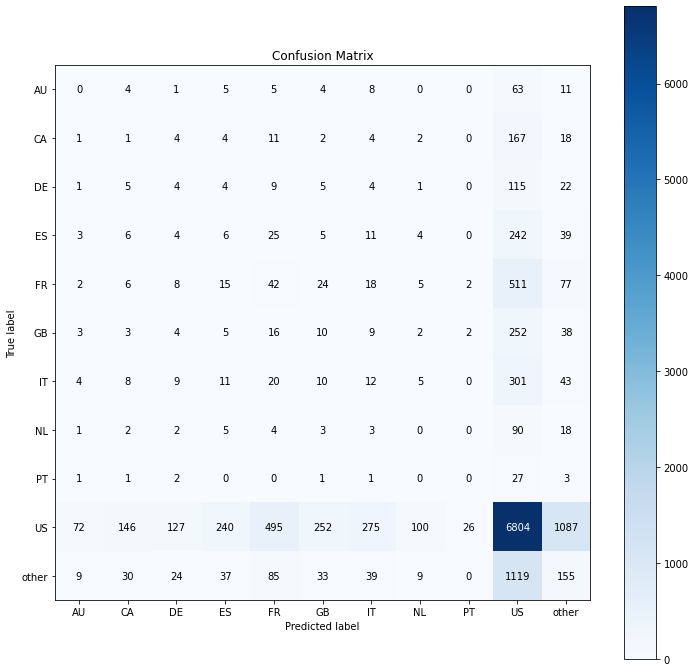

In [25]:
# Accuracy
acc_random = m.accuracy_score( y_test, yhat_random )
print( 'Accuracy: {}'.format( acc_random ) )

# Balanced Accuracy
balanced_accuracy_random = m.balanced_accuracy_score( y_test, yhat_random )
print( 'Balanced Accuracy: {}'.format( balanced_accuracy_random ) )

# Kappa Metrics
kappa_random = m.cohen_kappa_score( y_test, yhat_random )
print( 'Kappa Score: {}'.format( kappa_random ) )

# Classification Report
print( m.classification_report( y_test, yhat_random ) )

# Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat_random, normalize=False, figsize=(12, 12) )


### 5.2 Neural Network - MLP

In [26]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform( y_train.values.reshape( -1, 1 ) ).toarray()

In [27]:
y_train_nn

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [28]:
# model definition
model = ml.Sequential()
model.add( l.Dense( 128, input_dim=x_train.shape[1], activation='relu') )
model.add( l.Dense( 11, activation='softmax') )

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# train model
model.fit( x_train, y_train_nn, epochs=100 )

Epoch 1/100
1705/1705 [==============================] - 1s 618us/step - loss: 1.3278 - accuracy: 0.7054
Epoch 2/100
1705/1705 [==============================] - 1s 585us/step - loss: 1.2799 - accuracy: 0.7070
Epoch 3/100
1705/1705 [==============================] - 1s 504us/step - loss: 1.2325 - accuracy: 0.7079
Epoch 4/100
1705/1705 [==============================] - 1s 696us/step - loss: 1.2099 - accuracy: 0.7084
Epoch 5/100
1705/1705 [==============================] - 1s 655us/step - loss: 1.1965 - accuracy: 0.7085
Epoch 6/100
1705/1705 [==============================] - 1s 681us/step - loss: 1.1790 - accuracy: 0.7085
Epoch 7/100
1705/1705 [==============================] - 1s 646us/step - loss: 1.1581 - accuracy: 0.7087
Epoch 8/100
1705/1705 [==============================] - 1s 542us/step - loss: 1.1484 - accuracy: 0.7088
Epoch 9/100
1705/1705 [==============================] - 1s 488us/step - loss: 1.1425 - accuracy: 0.7087
Epoch 10/100
1705/1705 [==============================]

1705/1705 [==============================] - 1s 574us/step - loss: 1.0978 - accuracy: 0.7119
Epoch 79/100
1705/1705 [==============================] - 1s 651us/step - loss: 1.0972 - accuracy: 0.7117
Epoch 80/100
1705/1705 [==============================] - 1s 598us/step - loss: 1.0973 - accuracy: 0.7117
Epoch 81/100
1705/1705 [==============================] - 1s 554us/step - loss: 1.0974 - accuracy: 0.7121
Epoch 82/100
1705/1705 [==============================] - 1s 581us/step - loss: 1.0967 - accuracy: 0.7120
Epoch 83/100
1705/1705 [==============================] - 1s 595us/step - loss: 1.0967 - accuracy: 0.7122
Epoch 84/100
1705/1705 [==============================] - 1s 578us/step - loss: 1.0973 - accuracy: 0.7122
Epoch 85/100
1705/1705 [==============================] - 1s 642us/step - loss: 1.0962 - accuracy: 0.7119
Epoch 86/100
1705/1705 [==============================] - 1s 583us/step - loss: 1.0964 - accuracy: 0.7123
Epoch 87/100
1705/1705 [==============================] - 1

#### 5.2.1 NN Performance

In [29]:
# prediction
pred_nn = model.predict( x_test )

# invert prediction
yhat_nn = ohe.inverse_transform( pred_nn )

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape( 1, -1 )[0]

Accuracy: 0.7027502750275028
Balanced Accuracy: 0.09185914888499581
Kappa Score: 0.0015193125001173868


/home/victorpereira/.pyenv/versions/3.8.0/envs/airbnb_predict_first_booking/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       214
          DE       0.07      0.01      0.01       170
          ES       0.00      0.00      0.00       345
          FR       0.33      0.01      0.01       710
          GB       0.00      0.00      0.00       344
          IT       0.00      0.00      0.00       423
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        36
          US       0.71      0.99      0.83      9624
       other       0.22      0.00      0.01      1540

    accuracy                           0.70     13635
   macro avg       0.12      0.09      0.08     13635
weighted avg       0.54      0.70      0.58     13635



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

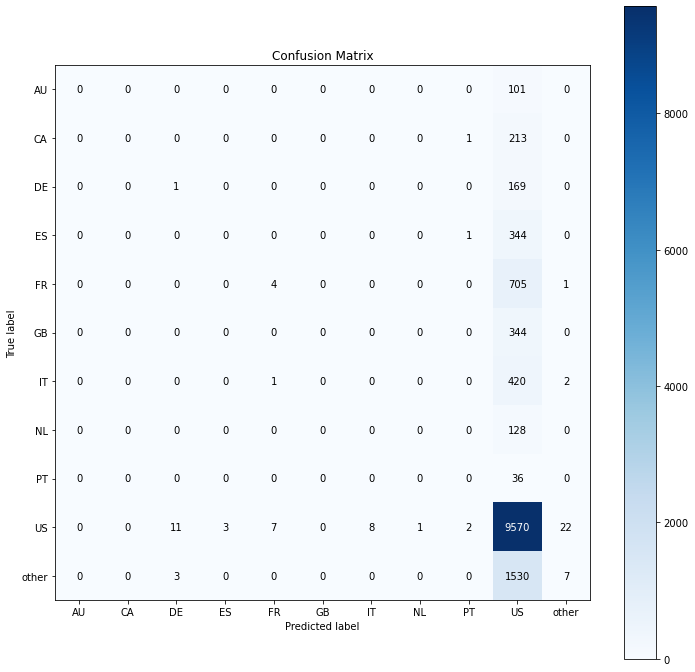

In [30]:
# Accuracy
acc_nn = m.accuracy_score( y_test_nn, yhat_nn )
print( 'Accuracy: {}'.format( acc_nn ) )

# Balanced Accuracy
balanced_accuracy_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
print( 'Balanced Accuracy: {}'.format( balanced_accuracy_nn ) )

# Kappa Metrics
kappa_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
print( 'Kappa Score: {}'.format( kappa_nn ) )

# Classification Report
print( m.classification_report( y_test_nn, yhat_nn ) )

# Confusion Matrix
mt.plot_confusion_matrix( y_test_nn, yhat_nn, normalize=False, figsize=(12, 12) )
